In [1]:
from pathlib import Path
import torch
import numpy as np
from skimage import io
import os

In [2]:
from dataset import getTrainValSplit, getTransforms, MatteDataset
from linknet import LinkNet34
from refinement_layer import MatteRefinementLayer

%load_ext line_profiler

In [3]:
# PATH = Path('/wdblue/deep_image_matting/Combined_Dataset/Training_set')
PATH = Path('/home/bread/telescope/deep_image_matting/data/train')
BG = PATH/'bg'
FG = PATH/'fg'
MASKS = PATH/'mask'
MODELS = Path('/home/bread/telescope/deep_image_matting/models')

In [4]:
train_fns, val_fns = getTrainValSplit(BG)
data_transform = getTransforms()
image_datasets = {'train': MatteDataset(train_fns, root_dir=PATH, fg_path=FG, transform=data_transform),
                  'val': MatteDataset(val_fns, root_dir=PATH, fg_path=FG, transform=data_transform)}

In [5]:
def read_random_fgs():
    fns = os.listdir(FG)
    for i in range(10):
        io.imread(FG/fns[np.random.randint(0, len(fns))])

In [ ]:
%%timeit
read_random_fgs()

In [13]:
%lprun -f io.imread io.imread(FG/'035A4516.jpg')

In [12]:
%lprun -f image_datasets['train'].__getitem__ image_datasets['train'].__getitem__(os.listdir(FG).index('035A4516.jpg'))

Loading  /wdblue/deep_image_matting/Combined_Dataset/Training_set/fg/035A4516.jpg


In [11]:
%%timeit


63.8 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
import os
os.listdir(FG)[0]

'035A4516.jpg'

0

In [14]:
FG

PosixPath('/wdblue/deep_image_matting/Combined_Dataset/Training_set/fg')

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ln = LinkNet34(1)
mrl = MatteRefinementLayer()
ln.load_state_dict(torch.load('models/modelv0_16.pt'))
mrl.load_state_dict(torch.load('models/refinev0_16.pt'))
ln = ln.to(device)
mrl = mrl.to(device)

In [6]:
idx = 3

In [14]:
%lprun --help

UsageError: option --help not recognized ( allowed: "rsf:m:D:T:u:" )


In [8]:
def loaddd(idx):
    return image_datasets['train'][idx]

In [35]:
%%timeit
sample = image_datasets['train'][idx]

73.6 ms ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
imap = sample['im_map']
img = imap[:3,:,:]
tri = imap[3,:,:]
m = sample['mask']
fg = sample['fg']
imap.shape, m.shape, tri.shape, fg.shape

(torch.Size([4, 320, 320]),
 torch.Size([1, 320, 320]),
 torch.Size([320, 320]),
 torch.Size([3, 320, 320]))

### Input Image

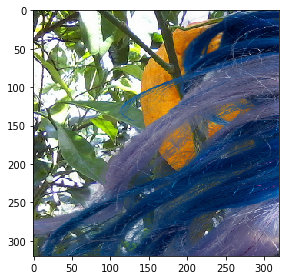

In [12]:
image = (img.numpy().transpose(1,2,0)*255).astype(np.uint8)
io.imshow(image)

### Input Trimap

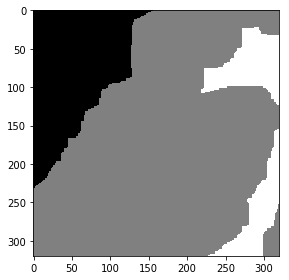

In [13]:
trimap = (tri.numpy()*255).astype(np.uint8)
io.imshow(trimap)

In [14]:
trimap.shape

(320, 320)

### Ground-Truth Matte

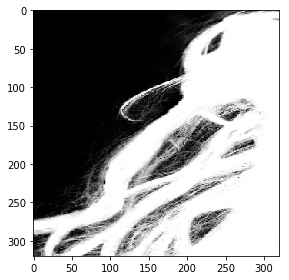

In [15]:
gt_matte = (m.numpy()[0]*255).astype(np.uint8)
io.imshow(gt_matte)

### Predicted Matte

In [16]:
inp = imap.unsqueeze(0).to(device)

In [26]:
%%timeit
out = ln(inp)

6.51 ms ± 3.55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
pm = mrl(torch.cat((inp[:,:3,:,:], out), 1))
pmn = (pm[0][0].cpu().detach().numpy()*255).astype(np.uint8)

In [65]:
# Using information from trimap

# pmn[np.equal(tri, 1).numpy().astype(np.bool)] = 255
# pmn[np.equal(tri, 0).numpy().astype(np.bool)] = 0

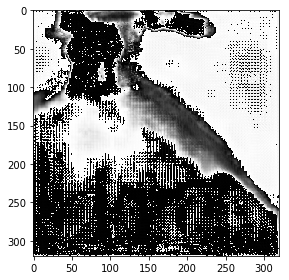

In [66]:
io.imshow(pmn)

### Foreground

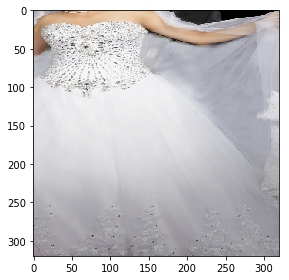

In [67]:
fore = (fg.numpy().transpose(1,2,0)).astype(np.uint8)
io.imshow(fore)

### Predicted Foreground

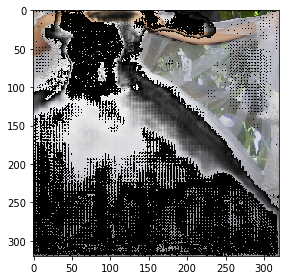

In [68]:
p_fore = np.multiply(image, (1/255)*np.expand_dims(pmn, -1)).astype(np.uint8)
io.imshow(p_fore)